## Problem Statement


Sérendipité is an article aggregation platform where articles from different domains such as technology, politics, news, and so on are shared by its users and then these articles are recommended on the basis of reading habits. 
They have a rating system for articles under which the users when they read the article rate it on a scale of 1 to 5.

We wish to explore the possibility of bringing personalized article recommendations to its customer base.
We will figure out, what we can achieve with collaborative filtering by accurately predicting ratings for each user article combination

_Trying all 3 techniques that we have learnt here and reporting which performs the best_

1. User Based Collaborative Filtering using Surprise Library
2. Item Based Collaborative Filtering using Surprise Library
3. Matrix Factorization Based Collaborative Filtering

## Data Description

train.csv

- **user_id**    --Unique ID for the user
- **article_id**   -- Unique ID for the article
- **rating**    --Rating provided by the user (1-5)



article_info.csv

- **website**    --Name of the website where the article is hosted
- **article_id**   -- Unique ID for the article
- **title**    --Title of the article
- **content**    --Complete text for the article


test.csv

- **user_id**    --Unique ID for the user
- **article_id**   -- Unique ID for the article


sample_submission.csv

- **user_id**    --Unique ID for the user
- **article_id**   -- Unique ID for the article
- **rating**    --Predicted rating for the user article combinations in the test file


Evaluation Metric: The evaluation metric for this problem is RMSE Score.

-----

**Final Submission**

1. Solution file contains the predicted rating for each user -article combination in the test set.

2. Code file for reproducing the submission






In [403]:
import os
os.chdir(r"D:\Datascience\Analytics vidya\LabAV\w19 Assignment 2  Article Recommendation using Collaborative Filtering\Article_Recommendation")

In [404]:
os.listdir()

['article_info.csv', 'sample_submission.csv', 'test.csv', 'train.csv']

## 1. Reading Dataset <a class="anchor" id="Reading-Dataset"></a>

In [405]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import mean_squared_error, pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [406]:
#Reading  Train file:
Train = pd.read_csv('train.csv')

#Reading Test file:
Test = pd.read_csv('test.csv')

#Reading sample_submission file:
sample_submission = pd.read_csv('sample_submission.csv')

#Reading Article Info File
article_info = pd.read_csv('article_info.csv')

## 2. Basic Exploration 

In [407]:
# Exploring train data

# shape of the users data
print(Train.shape)
# view the users data
Train.head()

(16731, 3)


,user_id,article_id,rating
0,1,456,1
1,1,2934,1
2,1,82,1
3,1,1365,1
4,1,221,1


In [408]:
Train.tail()

,user_id,article_id,rating
16726,1087,2242,1
16727,1087,419,1
16728,1087,784,1
16729,1087,1249,1
16730,1087,1692,1


In [409]:
#Unique values
Train.nunique()

user_id        907
article_id    2529
rating           5
dtype: int64

There are
- 907 Users
- 2529 articles &
- 5 ratings.


In [410]:
# duplicate values
Train.duplicated().sum()

0

In [411]:
Train.isna().sum() #number of missing values in each variable

user_id       0
article_id    0
rating        0
dtype: int64

So, we have 907 users in the dataset and each user has 2 features, i.e. article_id, rating.
There is a total of 2529 articles in the dataset.

We have 16731 ratings for different user and article combinations.

We have no missing and duplicated values in the user data.

----

In [412]:
# Exploring test data

# shape of the users data
print(Test.shape)
# view the users data
Test.head()

(7243, 2)


,user_id,article_id
0,1,2607
1,1,1445
2,1,911
3,1,857
4,1,2062


In [413]:
#Unique values
Test.nunique()

user_id        907
article_id    1882
dtype: int64

In [414]:
# duplicate values
Test.duplicated().sum()

0

In [415]:
Test.isna().sum() #number of missing values in each variable

user_id       0
article_id    0
dtype: int64

---

In [416]:
# Exploring article_info data

# shape of the data
print(article_info.shape)
# view the data
article_info.head()

(2529, 4)


,article_id,website,title,content
0,1025,uxmovement,Comment concevoir une procédure pas à pas que ...,par anthony le 18/07/16 à 8h02 Si une nouvelle...
1,2328,endeavor,Ressources humaines? Seulement si vous optez p...,"«Ambassadeurs», «avocats», «porte-parole» d'un..."
2,2469,linkedin,Deux motions de vente différentes. . . .,J'ai passé pas mal de temps récemment avec des...
3,2590,googleblog,Apprentissage large et profond: mieux avec Ten...,"""Apprenez les règles comme un pro, afin de pou..."
4,697,infoq,Agile: manque de compétences en tests,"Fran O'Hara, directeur et consultant principal..."


In [417]:
article_info.tail()

,article_id,website,title,content
2524,224,techcrunch,Kite veut être le compagnon de programmation e...,La plupart des environnements de développement...
2525,856,issuu,GRI Magazine 4e édition,"GRI, Club, Magazine, résidentiel, industriel, ..."
2526,2817,linkedin,4 tendances macro de la blockchain: où placer ...,Publié le Simon Taylor Suivre Abonné Ne plus s...
2527,839,googleblog,Spotify choisit Google Cloud Platform pour ali...,Ce n'est pas tous les jours que vous déplacez ...
2528,722,cnet,Watson d'IBM vise à rendre les séjours à l'hôp...,Ben Hider / Getty Images Ce n'est pas la même ...


In [418]:
#Unique values
article_info.nunique()

article_id    2529
website        788
title         2509
content       2518
dtype: int64

There are unique
- 2529 articles 
- 788 websites
- 2509 titles
- 2518 content


In [419]:
# duplicate values
article_info.duplicated().sum()

0

In [420]:
article_info.isna().sum() #number of missing values in each variable

article_id    0
website       0
title         0
content       0
dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Ratings distribution'}, xlabel='rating', ylabel='count'>

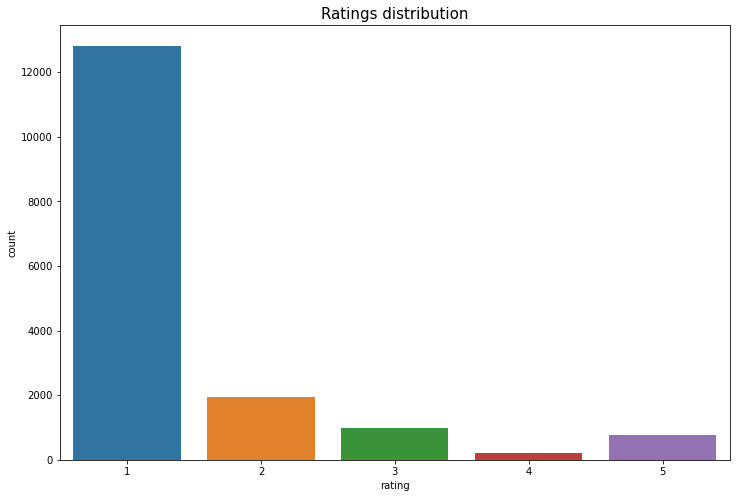

In [421]:
# Distribution of ratings

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Ratings distribution', fontsize=15)
ax.set_xlabel("ratings in interval")
ax.set_ylabel("Total number of ratings")
sns.countplot(Train['rating'])


In [422]:
# Ratings per user
ratings_per_user = Train.groupby(by='user_id')['rating'].count()#.sort_values(ascending=False)
ratings_per_user.describe()

count    907.000000
mean      18.446527
std       18.579884
min        5.000000
25%        7.000000
50%       12.000000
75%       22.000000
max      146.000000
Name: rating, dtype: float64

Minimum number of ratings given by a user = 5

Maximum number of ratings given by a user = 146

average ratings per user = 18

In [423]:
# Ratings per Article
ratings_per_Article = Train.groupby(by='article_id')['rating'].count()
ratings_per_Article.describe()

count    2529.000000
mean        6.615658
std         8.587884
min         1.000000
25%         2.000000
50%         4.000000
75%         8.000000
max       122.000000
Name: rating, dtype: float64

Minimum number of ratings recieved by an article = 1

Maximum number of ratings recieved by an article  = 122

average ratings recieved by an article  = 6

---

## 2.  Merging Article information to Train  and Test dataframe <a class="anchor" id="merge"></a>

The Article website name and Titles are contained in a separate file.

Let's merge that data with Train and Test and store it in the same. 

The idea is to bring Article website and title information in ratings dataframe as it would be useful later on.

In [424]:
train = pd.merge(Train, article_info, on='article_id', how='left')

In [425]:
test = pd.merge(Test, article_info, on='article_id', how='left')

In [426]:
train.head()

,user_id,article_id,rating,website,title,content
0,1,456,1,medium,"Obtenez 6 mois d'accès à Pluralsight, la plus ...","Obtenez 6 mois d'accès à Pluralsight, la plus ..."
1,1,2934,1,thestreet,La plateforme cloud de Google est désormais un...,Bien que la plate-forme Google Cloud (GCP) ne ...
2,1,82,1,facebook,La technologie derrière les photos d'aperçu,"Les premières impressions comptent, que vous s..."
3,1,1365,1,techcrunch,Les VM préemptives de Google Cloud Platform so...,"Pendant un certain temps, Google, Amazon et Mi..."
4,1,221,1,geekwire,Ray Kurzweil: Le monde ne se détériore pas - n...,"Ray Kurzweil, l'auteur, inventeur, informatici..."


Lets combine article_id , website and article title separated by ': ' and store it in a new column named Article

In [427]:
train['article_id'] = train['article_id'].map(str) + str(': ') + train['website'].map(str)+ str(': ')+ train['title'].map(str)

In [428]:
test['article_id'] = test['article_id'].map(str) + str(': ') + test['website'].map(str)+ str(': ')+ test['title'].map(str)

In [429]:
# Dropping 'website', 'title', 'content', 'article_id'
train = train.drop(['website', 'title', 'content'], axis = 1)

In [430]:
test = test.drop(['website', 'title', 'content'], axis = 1)

## 3. Creating Train & Test Data & Setting Evaluation Metric <a class="anchor" id="eval"></a>


In [431]:
#Assign X as the original ratings dataframe
X = train.copy()

#Split into training and test datasets
X_train, X_test = train_test_split(X, test_size = 0.25, random_state=42)

In [432]:
#Function that computes the root mean squared error (or RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

## 4. Importing Surprise & Loading Dataset <a class="anchor" id="dataload"></a>

In [433]:
#Importing functions to be used in this notebook from Surprise Package
from surprise import Dataset, Reader, SVD
from surprise.model_selection import GridSearchCV
from surprise.prediction_algorithms import KNNWithMeans


In [434]:
#Reader object to import ratings from X_train
reader = Reader(rating_scale=(1, 5))

#Storing Data in surprise format from X_train
data = Dataset.load_from_df(X_train[['user_id','article_id','rating']], reader)

## 5. [User based & Item based collaborative filtering with :  KNNwithMeans ]

## Grid Search for Neighbourhood size and similarity measure

 <a class="anchor" id="gridsearch"></a>

In [389]:
# Defining the parameter grid with k as the neighbourhood size ,
# min_K as the the minimum number of neighbors to take into account for aggregation & 
# trying 2 similarity measures --> cosine, pearson 
# & 5 fold Cross validation with KNNwithMeans 
# we also use user_based as True and false to try both user based and item based collaborative filtering
#and check which performs better

param_grid = {"k":list(range(1,50,3)),
               'min_k' : list(range(3,11,2)),
              "sim_options":{"name":["cosine","pearson"],'user_based': [True, False]}
             }

#Trying to find the best set of hyperparameters using Grid Search
gs = GridSearchCV(KNNWithMeans, 
                  param_grid, 
                  measures=['rmse'], 
                  cv=5, 
                  n_jobs = -1)

#We fit the grid search on data to find out the best score
gs.fit(data)

#Printing the best score
print(gs.best_score['rmse'])

#Printing the best set of parameters
print(gs.best_params['rmse'])

0.9628678827748185
{'k': 37, 'min_k': 9, 'sim_options': {'name': 'cosine', 'user_based': True}}


neighbourhood size K= 6,
minimum number of neighbors min_k :5,
similarity measures :pearson , with
user based collaborative filtering performs better

## 6. Fitting Model on complete train set & checking performance on test data<a class="anchor" id="testperf"></a>

In [435]:
#Defining similarity measure as per the best parameters
sim_options = {'name': 'pearson', 'user_based': True}

#Fitting the model on train data
model = KNNWithMeans(k = 37, min_k= 9 ,sim_options = sim_options)

#Build full trainset will essentially fits the knnwithmeans on the complete train set instead of a part of it
#like we do in cross validation
model.fit(data.build_full_trainset())

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [436]:
#id pairs for test set
id_pairs = zip(X_test['user_id'], X_test['article_id'])

#Making predictions for test set using predict method from Surprise
y_pred = [model.predict(uid = user, iid = article_id)[3] for (user, article_id) in id_pairs]

#Actual rating values for test set
y_true = X_test['rating']

# Checking performance on test set
rmse(y_true, y_pred)

0.9140066026939702

## 7. Matrix Factorization (SVD) Based Collaborative Filtering
## Grid Search for better performance with  on train set & checking performance on test  Dataset  <a class="anchor" id="gridsearch"></a>

In [392]:
#Defining the parameter grid for SVD and fixing the random state
param_grid = {'n_factors':list(range(1,120,5)), 'n_epochs': [5, 10, 20], 'random_state': [42]}

#Defining the grid search with the parameter grid and SVD algorithm optimizing for RMSE
gs = GridSearchCV(SVD, 
                  param_grid, 
                  measures=['rmse'], 
                  cv=5, 
                  n_jobs = -1)

#Fitting the model
gs.fit(data)
 
#Printing the best score
print(gs.best_score['rmse'])

#Printing the best set of parameters
print(gs.best_params['rmse'])

0.9452615861364023
{'n_factors': 1, 'n_epochs': 10, 'random_state': 42}


In [437]:
#Fitting the model on train data with the best parameters
model = SVD(n_factors = 1, n_epochs = 10, random_state = 42)

#Build full trainset will essentially fits the SVD on the complete train set instead of a part of it
#like we do in cross validation for grid search
model.fit(data.build_full_trainset())

In [438]:
#id pairs for test set
id_pairs = zip(X_test['user_id'], X_test['article_id'])

#Making predictions for test set using predict method from Surprise
y_pred = [model.predict(uid = user, iid = article_id)[3] for (user, article_id) in id_pairs]

#Actual rating values for test set
y_true = X_test['rating']

# Checking performance on test set
rmse(y_true, y_pred)

0.9086528133002789

### Tuning 
1. Learning Rate (lambda) (lr_all)
2. Regularization Parameter (gamma)  (reg_all)

to improve the performance further by controling overfitting.


In [396]:
param_grid = {'n_factors':list(range(1,50,5)), 'n_epochs': [5, 10, 20], 'random_state': [42], "lr_all": [0.002, 0.005], "reg_all": [0.4, 0.6]
}

#Defining the grid search with the parameter grid and SVD algorithm optimizing for RMSE
gs = GridSearchCV(SVD, 
                  param_grid, 
                  measures=['rmse'], 
                  cv=5, 
                  n_jobs = -1)

#Fitting the model
gs.fit(data)
 
#Printing the best score
print(gs.best_score['rmse'])

#Printing the best set of parameters
print(gs.best_params['rmse'])


0.9456135779549873
{'n_factors': 11, 'n_epochs': 20, 'random_state': 42, 'lr_all': 0.005, 'reg_all': 0.4}


In [439]:
#Fitting the model on train data with the best parameters
model = SVD(n_factors = 11, n_epochs = 20, random_state = 42, lr_all= 0.005, reg_all= 0.4)

#Build full trainset will essentially fits the SVD on the complete train set instead of a part of it
#like we do in cross validation for grid search
model.fit(data.build_full_trainset())

In [440]:
#id pairs for test set
id_pairs = zip(X_test['user_id'], X_test['article_id'])

#Making predictions for test set using predict method from Surprise
y_pred = [model.predict(uid = user, iid = article_id)[3] for (user, article_id) in id_pairs]

#Actual rating values for test set
y_true = X_test['rating']

# Checking performance on test set
rmse(y_true, y_pred)

0.9104292198027232

## Step 8: Prepare submission file with final prediction

### Taking Predictions for Test Dataset

In [441]:
sample_submission.head()

,user_id,article_id,rating
0,1,2607,1
1,1,1445,1
2,1,911,1
3,1,857,1
4,1,2062,1


In [442]:
#id pairs for Test set
id_pairs = zip(sample_submission['user_id'], sample_submission['article_id'])

#Making predictions for test set using predict method from Surprise
y_pred = [model.predict(uid = user_id, iid = article_id)[3] for (user_id, article_id) in id_pairs]


In [454]:
Nirmal_submission = pd.DataFrame({'user_id': sample_submission['user_id'], 'article_id': sample_submission['article_id'], 'rating': y_pred})

In [456]:
Nirmal_submission.to_csv(r'D:\Datascience\Analytics vidya\LabAV\w19 Assignment 2  Article Recommendation using Collaborative Filtering\Article_Recommendation\Nirmal_submission.csv', index=False)